# Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_addons
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 2.1 MB/s eta 0:00:00


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

In [4]:
from google.colab.patches import cv2_imshow
from skimage import measure
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import pickle
import tensorflow as tf
from tensorflow import keras
import cv2
import tarfile
import tensorflow_datasets as tfds
from keras.layers import SpatialDropout2D,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
# from keras.engine import functional
from numpy import unravel_index
from functools import partial
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D,MaxPooling2D,Conv1D,Cropping2D,Concatenate,Dropout,BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import Concatenate
from keras.models import load_model
from keras.initializers import RandomNormal
from keras.layers import SpatialDropout2D
import albumentations as A
import warnings
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tempfile
import copy
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from zipfile import ZipFile
from natsort import natsorted
from utilities import *
import time
from PIL import Image
import math

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Laoding model from google drive

In [5]:
def mean_iou(y_true, y_pred):
  y_pred = tf.where(y_pred>0.5, 1, 0)
  y_pred = tf.round(tf.cast(y_pred, tf.int32))
  intersect = tf.reduce_sum(tf.cast(y_true, tf.float32) * tf.cast(y_pred, tf.float32), axis=[1])
  union = tf.reduce_sum(tf.cast(y_true, tf.float32),axis=[1]) + tf.reduce_sum(tf.cast(y_pred, tf.float32),axis=[1])
  smooth = tf.ones(tf.shape(intersect))
  return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def sec_accuracy(y_true, y_pred):
  y_pred = tf.where(y_pred>0.5, 1, 0)
  y_pred = tf.round(tf.cast(y_pred, tf.int32))
  y_true = tf.round(tf.cast(y_true, tf.int32))
  return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

In [6]:
# setting model path
save_path = '/content/drive/My Drive/dental/model/ResUNET/model_o16.keras'
# model_test = keras.models.load_model(save_path,
#                                      custom_objects={'sec_accuracy':sec_accuracy,
#                                                      'mean_iou':mean_iou})
model_test = keras.models.load_model(save_path, compile=False)


In [7]:
def make_prediction(image_path, model_test, threshold):
  img = keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(512, 512))
  img_array = tf.keras.utils.img_to_array(img)
  img_array_batch = np.expand_dims(img_array, axis=0)
  img_array_batch = np.reshape(img_array_batch, (1, 512, 512, 1))
  img_array_batch = img_array_batch/255
  img_prediction = model_test.predict(img_array_batch)
  img_tooth = img_prediction[0,:,:,0]
  img_tooth_thresh = np.where(img_tooth>threshold, 1, 0)
  plt.imshow(img_tooth_thresh, cmap="gray")

  return img_tooth_thresh


# Load image

In [8]:
def crop_img(image_path):
  img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  img_array = img_array[11:-11,:]
  print(img_array.shape)
  while np.sum(img_array[0])==0:
    img_array=np.delete(img_array, 0, axis=0)
  while np.sum(img_array[-1])==0:
    img_array=np.delete(img_array, -1, axis=0)
  while np.sum(img_array[:,0])==0:
    img_array=np.delete(img_array, 0, axis=1)
  while np.sum(img_array[:,-1])==0:
    img_array=np.delete(img_array, -1, axis=1)
  print(img_array.shape)
  plt.imshow(img_array, cmap="gray")
  plt.show()
  return img_array


def crop_rbg_img(image_path):
  img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  rgb_array = cv2.imread(image_path)
  img_array = img_array[11:-11,:]
  rgb_array = rgb_array[11:-11,:]
  print(img_array.shape)
  print(rgb_array.shape)
  while np.sum(img_array[0])==0:
    img_array=np.delete(img_array, 0, axis=0)
    rgb_array=np.delete(rgb_array, 0, axis=0)
  while np.sum(img_array[-1])==0:
    img_array=np.delete(img_array, -1, axis=0)
    rgb_array=np.delete(rgb_array, -1, axis=0)
  while np.sum(img_array[:,0])==0:
    img_array=np.delete(img_array, 0, axis=1)
    rgb_array=np.delete(rgb_array, 0, axis=1)
  while np.sum(img_array[:,-1])==0:
    img_array=np.delete(img_array, -1, axis=1)
    rgb_array=np.delete(rgb_array, -1, axis=1)
  print(img_array.shape)
  print(rgb_array.shape)
  plt.imshow(img_array, cmap="gray")
  plt.show()
  plt.imshow(rgb_array)
  plt.show()
  return img_array, rgb_array


(847, 1504)
(847, 1504)


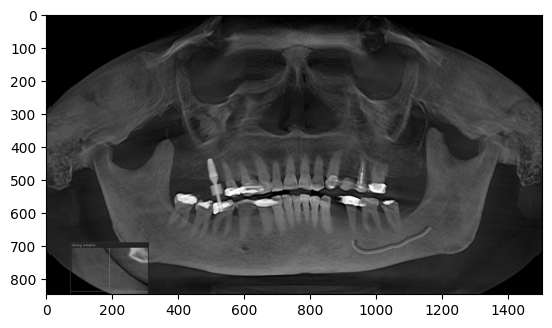

(847, 1504)
(847, 1504, 3)
(847, 1504)
(847, 1504, 3)


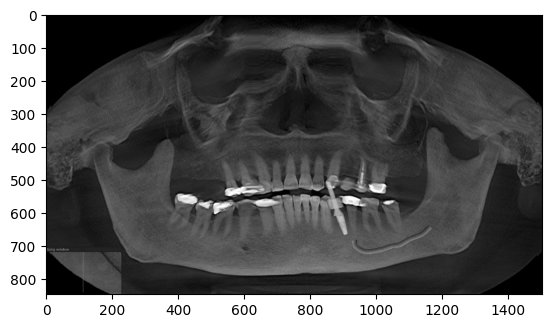

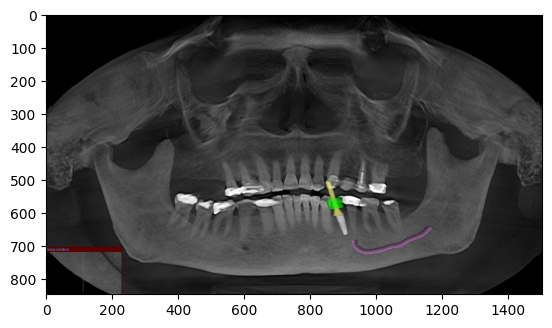

In [446]:
# image_path = "/content/drive/MyDrive/dental/data/Test with implant/1303280.JPG"
# image2_path = "/content/drive/MyDrive/dental/data/Test with implant/1303280i.JPG"
image_path = "/content/drive/MyDrive/dental/data/test_implant_3/2113537.JPG"
image2_path = "/content/drive/MyDrive/dental/data/test_implant_3/2113537i.JPG"
image_grayscale = crop_img(image_path)
image_implant, image_rgb = crop_rbg_img(image2_path)

1/1 [==============================] - 4s 4s/step


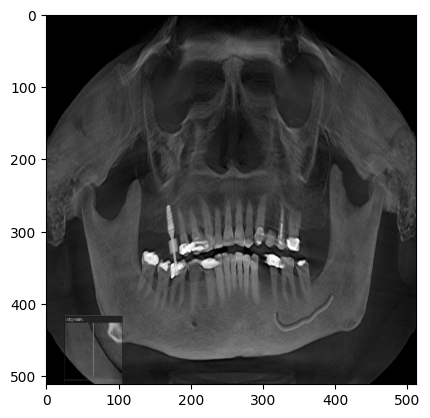

In [447]:
gray_img = cv2.resize(image_grayscale, (512,512))
img_array_batch = np.expand_dims(gray_img, axis=0)
img_array_batch = np.reshape(img_array_batch, (1, 512, 512, 1))
img_array_batch = img_array_batch/255
img_prediction = model_test.predict(img_array_batch)
plt.imshow(gray_img.astype(np.uint8),cmap='gray')
plt.show()

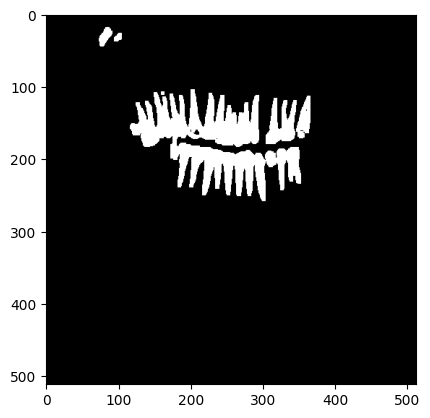

In [449]:
img_tooth = img_prediction[0,:,:,0]   #+ img_prediction[0,:,:,1]
img_tooth_thresh = np.where(img_tooth>0.99, 1, 0)

img_tooth_thresh=img_tooth_thresh[::-1,:]
kernel = np.ones((5,5))
img_tooth_thresh = cv2.erode(img_tooth_thresh.astype('uint8'), kernel, iterations=1)
img_tooth_thresh = cv2.dilate(img_tooth_thresh.astype('uint8'), kernel, iterations=1)


plt.imshow(img_tooth_thresh, cmap="gray")
num_rows, num_cols = img_tooth_thresh.shape

# Create arrays for x and y coordinates using meshgrid
x_coords, y_coords = np.meshgrid(np.arange(num_rows), np.arange(num_cols))

# Flatten the coordinate arrays and the original array A
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
A_flat = img_tooth_thresh.flatten()

# Create a pandas DataFrame
img_tooth_df = pd.DataFrame({'x': x_flat, 'y': y_flat, 'value': A_flat})


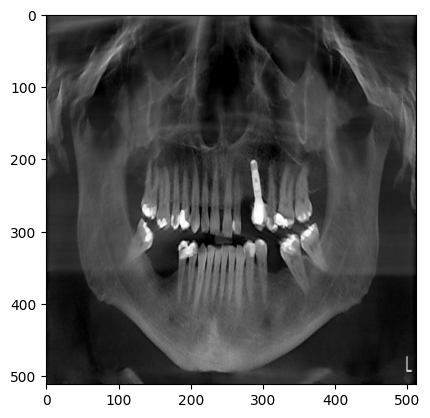

1/1 [==============================] - 3s 3s/step


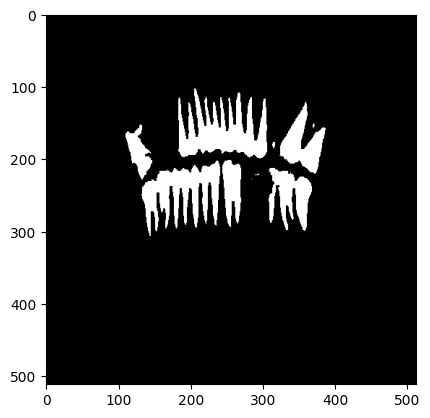

In [12]:
i_num = 36
loaded_data_x=np.load('/content/drive/My Drive/dental/model/ResUNET/xte.npy')
loaded_data_y=np.load('/content/drive/My Drive/dental/model/ResUNET/yte.npy')
img_array=loaded_data_x[i_num,:,:,0]
plt.imshow(img_array, cmap="gray")
plt.show()
img_array_batch = np.expand_dims(img_array, axis=0)
img_array_batch = np.reshape(img_array_batch, (1, 512, 512, 1))
img_prediction=model_test.predict(img_array_batch)
img_tooth = img_prediction[0,:,:,0]
img_tooth_thresh = np.where(img_tooth>0.99, 1, 0)
img_tooth_thresh=img_tooth_thresh[::-1,:]
kernel = np.ones((3,3))
img_tooth_thresh = cv2.erode(img_tooth_thresh.astype('uint8'), kernel, iterations=1)
plt.imshow(img_tooth_thresh, cmap="gray")

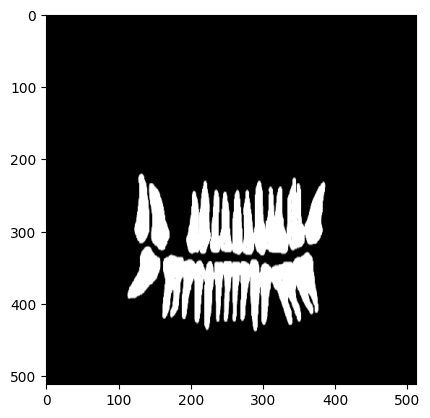

In [13]:
image_path = "/content/drive/MyDrive/dental/data/data_merge/Tooth/2.png"
img_truth = keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(512, 512))
img_truth = tf.keras.utils.img_to_array(img_truth)
plt.imshow(img_truth, cmap="gray")

In [14]:
## setting image path

# image_path = "/content/drive/MyDrive/dental/data/Test with implant/1072164_c.png"
# image = keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(512, 512))
# gray_img = tf.keras.utils.img_to_array(image).astype(np.uint8)
gray_img = cv2.resize(image2, (512,512))
# print(np.min(gray_img),np.max(gray_img), gray_img.dtype)
# gray_img = cv2.equalizeHist(gray_img)
# gray_img = (gray_img-np.min(gray_img))/(np.max(gray_img)-np.min(gray_img))*255
# Apply a Gaussian blur to reduce noise (optional but recommended)
# blurred_image = cv2.GaussianBlur(gray_img, (5, 5), 0)
# Apply the Laplacian filter to enhance edges
# sharp_image = cv2.Laplacian(blurred_image, cv2.CV_8U, ksize=5)
# Increase the contrast by subtracting the sharp image from the original image
# gray_img  = cv2.addWeighted(gray_img, 1.5, sharp_image, -0.5, 0)
# gray_img=((gray_img/255)**1.15*255).astype(np.uint8)
# Create the sharpening kernel
# kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
# Sharpen the image
# gray_img = cv2.filter2D(gray_img, -1, kernel)
# gray_img =( (gray_img-np.min(gray_img))/(np.max(gray_img)-np.min(gray_img))*255).astype(np.uint8)
# print(np.min(gray_img),np.max(gray_img), gray_img.dtype)
# gray_img = cv2.normalize(gray_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
# gray_img  = (255*gray_img).astype(np.uint8)
# img = keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(512, 512))
# img_original = keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size=(512, 512))
# img_original_array = tf.keras.utils.img_to_array(img_original)
# mask = (np.abs(img_original_array[:, :, 0] - img_original_array[:, :, 1])<=30) & (np.abs(img_original_array[:, :, 0]- img_original_array[:, :, 2])<=30)
# filtered_array = np.copy(img_original_array)
# filtered_array[~mask] = 30
# gray_image = cv2.cvtColor(filtered_array, cv2.COLOR_BGR2GRAY)
# img_array = tf.keras.utils.img_to_array(gray_img)
# img_array_batch = np.expand_dims(img_array, axis=0)
img_array_batch = np.expand_dims(gray_img, axis=0)
img_array_batch = np.reshape(img_array_batch, (1, 512, 512, 1))
img_array_batch = img_array_batch/255
img_prediction = model_test.predict(img_array_batch)
# plt.imshow(img_array, cmap="gray")
# plt.show()
plt.imshow(gray_img.astype(np.uint8),cmap='gray')
plt.show()

NameError: ignored

In [ ]:
# temp_img=  np.clip(gray_img.astype(int) - 30, 0, 255)
temp_img = gray_img.astype(int).copy()
temp_img[temp_img<50]=0
plt.imshow(temp_img.astype(np.uint8),cmap='gray')
plt.show()
img_array_batch = np.expand_dims(temp_img, axis=0)
img_array_batch = np.reshape(img_array_batch, (1, 512, 512, 1))
img_array_batch = img_array_batch/255
img_prediction = model_test.predict(img_array_batch)
img_tooth = img_prediction[0,:,:,0]+img_prediction[0,:,:,1]
img_tooth_thresh = np.where(img_tooth>0.5, 1, 0)
plt.imshow(img_tooth_thresh, cmap="gray")

In [ ]:
img_tooth = img_prediction[0,:,:,0] +img_prediction[0,:,:,1]
img_tooth_thresh = np.where(img_tooth>0.7, 1, 0)

img_tooth_thresh=img_tooth_thresh[::-1,:]

# kernel = np.ones((5,5))
# img_tooth_thresh = cv2.erode(img_tooth_thresh.astype('uint8'), kernel, iterations=1)
# img_tooth_thresh = cv2.dilate(img_tooth_thresh.astype('uint8'), kernel, iterations=1)


plt.imshow(img_tooth_thresh, cmap="gray")

In [ ]:
num_rows, num_cols = img_tooth_thresh.shape

# Create arrays for x and y coordinates using meshgrid
x_coords, y_coords = np.meshgrid(np.arange(num_rows), np.arange(num_cols))

# Flatten the coordinate arrays and the original array A
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
A_flat = img_tooth_thresh.flatten()

# Create a pandas DataFrame
img_tooth_df = pd.DataFrame({'x': x_flat, 'y': y_flat, 'value': A_flat})

img_tooth_df

# Find Main Axes using prediction

(512.0, 0.0)

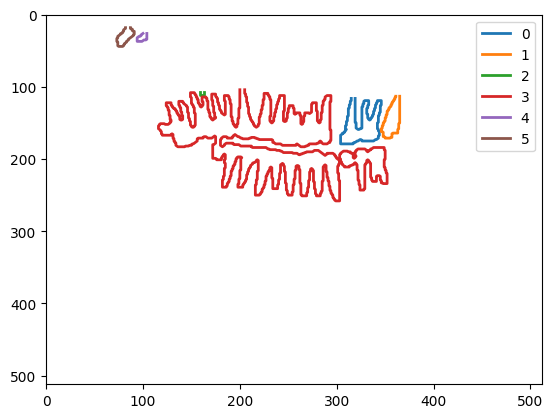

In [450]:
image = (img_tooth_thresh*255).astype('uint8')
cnts, hierachy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
draw_img = image.copy()
ret = cv2.drawContours(draw_img, cnts, -1, (0, 0, 255), 2)
# draw contours
fig, ax = plt.subplots()
flag = 0
for i in cnts:
    ax.plot(i[:,0,0], i[:,0,1], linewidth=2, label=flag)
    flag+=1
ax.legend()
ax.set_xlim(0, image.shape[1])
ax.set_ylim(image.shape[0], 0)

In [19]:
def plot_2figs(cnts, num1, num2):

  fig, ax = plt.subplots()
  # ax.imshow(gray, cmap=plt.cm.gray)


  # for contour in contours:
  #     ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
  # 5, 7
  ax.plot(cnts[num1][:,0,0], cnts[num1][:,0,1], linewidth=2)
  ax.plot(cnts[num2][:,0,0], cnts[num2][:,0,1], linewidth=2)
  ax.set_xlim(0, image.shape[1])
  ax.set_ylim( image.shape[0], 0)
  #ax.plot(331.03303919, 373.59564548, marker='o')
  #ax.plot(331.03303919+16.71734244, 373.59564548+79.7645965, marker='o')
  return

In [20]:
def find_upper(image_cnts, threshold):
  #fig, ax = plt.subplots()
  #ax.plot(cnts[8][:,0,0], cnts[8][:,0,1])
  tooth_image_pd = pd.DataFrame(image_cnts)
  tooth_image_pd.columns = ['x','y']
  #seaborn.kdeplot(tooth_image_pd['y'])
  upper = tooth_image_pd[tooth_image_pd['y']<threshold]
  return upper

In [21]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

In [435]:
def find_dividing_points(upper):
  upper_image = upper.sort_values(by=['x','y']).reset_index(drop=True).copy()
  upper_image = upper.copy()
  upper_image['delta'] = 0
  upper_image['delta2'] = 0
  for i in range(1, len(upper_image)-1):
    delta1 = (np.mean(upper_image.iloc[i+1:i+2,1])  - upper_image.iloc[i,1]) / max(np.mean(upper_image.iloc[i+1:i+2,0])  - upper_image.iloc[i,0], 0.01)
    delta2 = (upper_image.iloc[i,1]  - np.mean(upper_image.iloc[i-2:i-1,1])) / max(upper_image.iloc[i,0]  - np.mean(upper_image.iloc[i-2:i-1,0]), 0.01)
    upper_image.iloc[i,2] = (delta1+delta2)/2
  for i in range(2, len(upper_image)-2):
    delta1 = (upper_image.iloc[i+1,2]  - upper_image.iloc[i,2]) / max(upper_image.iloc[i+1,0]  - upper_image.iloc[i,0], 0.01)
    delta2 = (upper_image.iloc[i,2]  - upper_image.iloc[i-1,2]) / max(upper_image.iloc[i,0]  - upper_image.iloc[i-1,0], 0.01)
    upper_image.iloc[i,3] = (delta1+delta2)/2
  # plt.plot(upper_image.iloc[2:len(upper)-1,0], upper_image.iloc[2:len(upper)-1,2])
  # plt.show()
  # plt.plot(upper_image.iloc[2:len(upper)-1,0], upper_image.iloc[2:len(upper)-1,3])
  # plt.show()
  # dividing_points = upper_image[(np.abs(upper_image['delta'])<=0.1) & (upper_image['x']>=(upper_image['x'].min()+45))&
  #                       (upper_image['x']<=(upper_image['x'].max()-45)) & (np.abs(upper_image['delta'])<=0.1)]['x']
  dividing_points_index = upper_image[(np.abs(upper_image['delta'])<=0.5) & (upper_image['x']>=(upper_image['x'].min()+10))&
                        (upper_image['x']<=(upper_image['x'].max()-10))].index

  # plt.plot(upper_image.iloc[2:len(upper_image)-2,0], upper_image.iloc[2:len(upper_image)-2,2])

  final_list = []
  for p in dividing_points_index:
    if (np.mean(upper_image.iloc[p-1,3])* np.mean(upper_image.iloc[p+1,3])) <= 0: final_list.append(p)
  # final_list = dividing_points_index.values

  dividing_points = upper.iloc[final_list,0].values
  fig, ax = plt.subplots()
  ax.plot(upper['x'], upper['y'],'b')
  for i in dividing_points:
    plt.axvline(x=i, color='g')
  plt.show()
  print(dividing_points)
  return dividing_points

In [361]:
def extract_left_right(left, right, left_threshold, right_threshold, left_flag, right_flag, smooth_left, smooth_right, left_threshold_y, right_threshold_y):
  tooth_image_pd_right = pd.DataFrame(right)
  tooth_image_pd_right.columns=['x','y']
  right_dividing_points = []
  left_dividing_points = []
  right_upper = find_upper(right, right_threshold)
  right_upper =  right_upper.sort_values(by=['x','y']).reset_index(drop=True)
  if smooth_right:
    # right_upper =  right_upper.sort_values(by=['x','y']).reset_index(drop=True)
    right_upper_c = right_upper.copy()
    smoothed_right_y = smoothTriangle(right_upper_c['y'], 10)
    # plt.plot(right_upper_c['x'], smoothed_right_y)
    # plt.plot(right_upper_c['x'], right_upper['y'])
    right_upper_c['y'] = smoothed_right_y
    right_dividing_points = find_dividing_points(right_upper_c)
    print(right_dividing_points)
    # right_dividing_points = find_dividing_points(right_upper)
  else:
    right_dividing_points = find_dividing_points(right_upper)
  if (right_flag == True) & (len(right_dividing_points)!=0):
    right_part = tooth_image_pd_right[(tooth_image_pd_right['x']<= np.min(right_dividing_points)) & (tooth_image_pd_right['y']<= right_threshold_y)]
  else:
    right_part = tooth_image_pd_right
  tooth_image_pd_left = pd.DataFrame(left)
  tooth_image_pd_left.columns=['x','y']

  left_upper = find_upper(left, left_threshold)
  left_upper =  left_upper.sort_values(by=['x','y']).reset_index(drop=True)
  if smooth_left:
    left_upper_c = left_upper.copy()
    smoothed_left_y = smoothTriangle(left_upper_c['y'], 20)
    left_upper_c['y'] = smoothed_left_y
    left_dividing_points = find_dividing_points(left_upper_c)
    # left_dividing_points = find_dividing_points(left_upper)
  else:
    left_dividing_points = find_dividing_points(left_upper)
  if (left_flag == True) & (len(left_dividing_points)!=0):
    left_part = tooth_image_pd_left[tooth_image_pd_left['x']>= np.max(left_dividing_points)]
  else:
    left_part = tooth_image_pd_left
  left_part = left_part[left_part['y']<= left_threshold_y]
  right_part = right_part[right_part['y']<= right_threshold_y]
  fig, ax = plt.subplots()
  ax.plot(left_part['x'],left_part['y'], linewidth=2)
  ax.plot(right_part['x'],right_part['y'], linewidth=2)
  ax.set_xlim(0, 511)
  ax.set_ylim(511, 0)
  return left_part, right_part

In [24]:
### PCA
#a = left_part.values
def PCA_fit(a):
  pca = PCA()
  new_XY = pca.fit_transform(a)
  v = [0,0]
  count = 0
  for length, vector in zip(pca.explained_variance_, pca.components_):
    v[count] = vector * 3 * np.sqrt(length)
    count += 1
  x_line = [pca.mean_[0],pca.mean_[0]+v[0][0],pca.mean_[0]-v[0][0]]
  y_line = [pca.mean_[1],pca.mean_[1]+v[0][1],pca.mean_[1]-v[0][1]]
  # plt.plot(x_line, y_line)
  # top right
  b = a[a[:,0] > pca.mean_[0]]
  max_r = max(b[b[:,1] > pca.mean_[1],1])
  # top left
  b = a[a[:,0] < pca.mean_[0]]
  max_l = max(b[b[:,1] > pca.mean_[1],1])
  # bottom right
  b = a[a[:,0] > pca.mean_[0]]
  min_r = min(b[b[:,1] < pca.mean_[1],1])
  # bottom left
  b = a[a[:,0] < pca.mean_[0]]
  min_l = min(b[b[:,1] < pca.mean_[1],1])
  c = a[(a[:,1] >= min_r) & (a[:,1] <= max_r)]
  new_XY_edit = pca.fit_transform(c)
  v = [0,0]
  count = 0
  for length, vector in zip(pca.explained_variance_, pca.components_):
    v[count] = vector * 3 * np.sqrt(length)
    count += 1
  x_line = np.array([pca.mean_[0]-v[0][0],pca.mean_[0],pca.mean_[0]+v[0][0]])
  y_line = np.array([pca.mean_[1]-v[0][1],pca.mean_[1],pca.mean_[1]+v[0][1]])
  plt.plot(a[:,0], a[:,1])
  plt.plot(x_line, y_line)
  plt.plot(pca.mean_[0], pca.mean_[1], marker = 'o')
  plt.xlim(0, 511)
  plt.ylim(511,0)
  return np.array([x_line, y_line])

In [25]:
def compute_central_line(a, b):
  a = a.values
  left_line = PCA_fit(a)
  left_max = left_line[:, np.argmax(left_line[1])]
  left_min = left_line[:, np.argmin(left_line[1])]
  left_middle = left_line[:, 1]
  b = b.values
  right_line = PCA_fit(b)
  right_max = right_line[:, np.argmax(right_line[1])]
  right_min = right_line[:, np.argmin(right_line[1])]
  right_middle = right_line[:, 1]
  final_line = np.array([left_max+right_max, left_middle+right_middle, left_min+right_min])/2
  #plt.plot(final_line[:,0], final_line[:,1])
  return final_line

In [26]:
def compute_final(cnts, final_line_x, final_line_y):
  fig, ax = plt.subplots()
  for i in cnts:
    ax.plot(i[:,0,0], i[:,0,1], linewidth=2)
  ax.plot(final_line_x, final_line_y)
  ax.set_xlim(0, 511)
  ax.set_ylim(511, 0)

# Computation


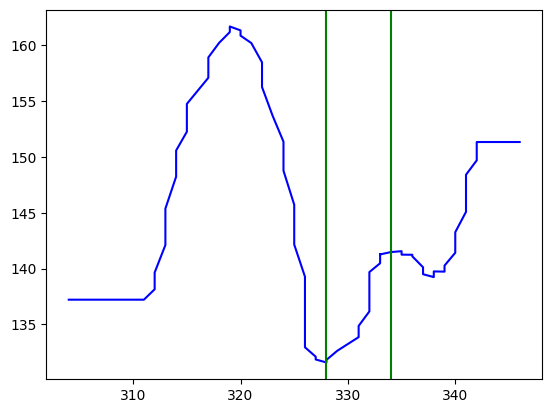

[328 334]
[328 334]


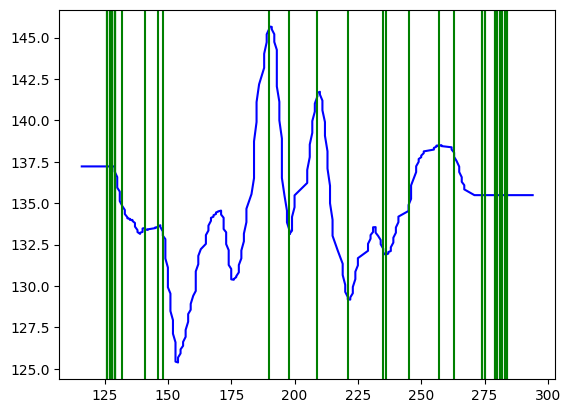

[126 126 126 127 127 128 128 128 128 129 129 129 129 132 141 146 148 190
 198 209 221 235 236 245 257 263 274 274 275 275 279 279 280 280 281 281
 282 283 283 284 284]


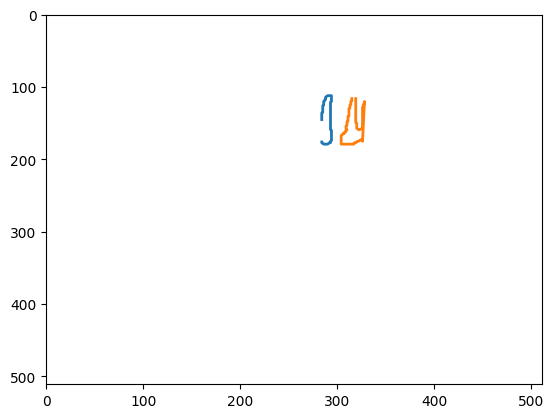

In [454]:
left_part, right_part = extract_left_right(cnts[3][:,0,:], cnts[0][:,0,:],170, 180, True, True, True, True, 180,999)

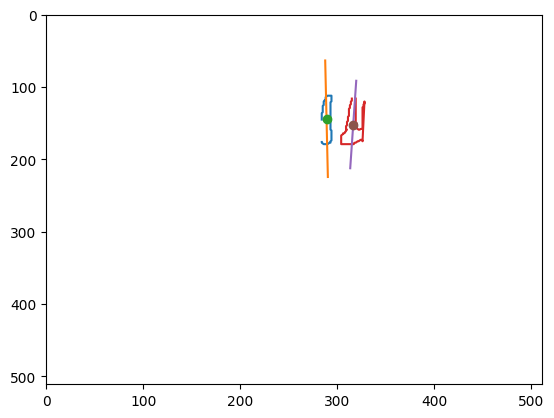

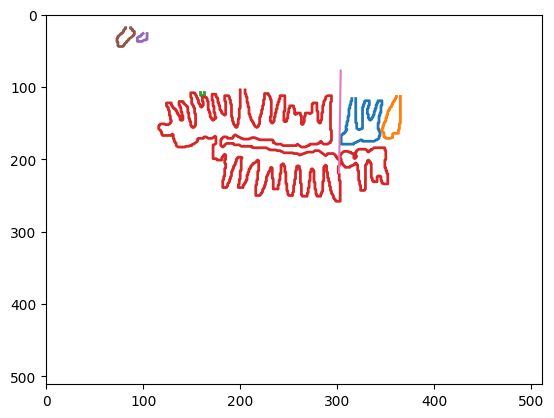

In [455]:
final_line = compute_central_line(left_part, right_part)
compute_final(cnts, final_line[:,0], final_line[:,1])

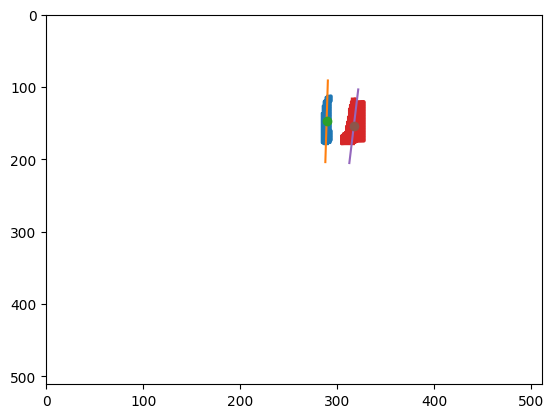

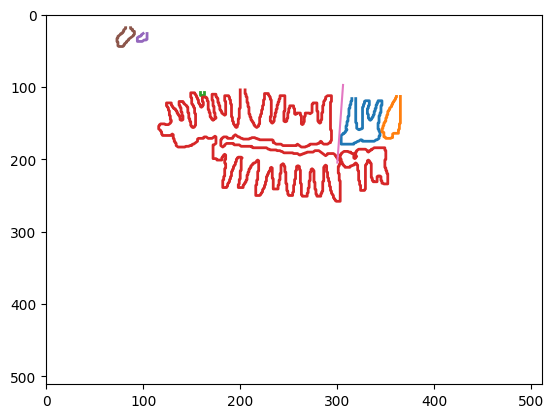

In [458]:
left_box_x_max = left_part['x'].max()
left_box_x_min = left_part['x'].min()
left_box_y_min = left_part['y'].min()
left_box_y_max = left_part['y'].max()
left_part_all = img_tooth_df[(img_tooth_df['x']<=left_box_x_max) &
(img_tooth_df['x']>=left_box_x_min) &
  (img_tooth_df['y']<=left_box_y_max) &
   (img_tooth_df['y']>=left_box_y_min) &
   (img_tooth_df['value']==1)]
#PCA_fit(left_part_all[['x','y']].values)
right_box_x_max = right_part['x'].max()
right_box_x_min = right_part['x'].min()
right_box_y_min = right_part['y'].min()
right_box_y_max = right_part['y'].max()
right_part_all = img_tooth_df[(img_tooth_df['x']<=right_box_x_max) &
(img_tooth_df['x']>=right_box_x_min) &
  (img_tooth_df['y']<=right_box_y_max) &
   (img_tooth_df['y']>=right_box_y_min) &
   (img_tooth_df['value']==1)]
#PCA_fit(right_part_all[['x','y']].values)
# final_line_all = compute_central_line(left_part_all[['x','y']], right_part)
# final_line_all = compute_central_line(left_part, right_part_all[['x','y']])
final_line_all = compute_central_line(left_part_all[['x','y']], right_part_all[['x','y' ]])
compute_final(cnts, final_line_all[:,0], final_line_all[:,1])

# Make implant

In [40]:
def add_line_to_xray(final_line, image):
  new_image = image.copy()
  final_line_reg = LinearRegression().fit(final_line[:,0].reshape(-1,1),final_line[:,1])
  final_line_slope = final_line_reg.coef_[0]
  final_line_intercept = final_line_reg.intercept_
  start_point_y = int(np.floor(np.min(final_line[:,1])))
  end_point_y = int(np.ceil(np.max(final_line[:,1])))
  for i in range (start_point_y, end_point_y+1):
    implant_x = (i - final_line_intercept) / final_line_slope
    implant_x_max = int(np.ceil(implant_x))
    implant_x_min = int(np.floor(implant_x))
    for j in range(implant_x_min, implant_x_max+1):
      new_image[i, j] = 255.0
  plt.imshow(new_image, cmap="gray")
  return new_image

In [65]:
def add_line_to_rgb(final_line, image):
  new_image = image.copy()
  final_line_reg = LinearRegression().fit(final_line[:,0].reshape(-1,1),final_line[:,1])
  final_line_slope = final_line_reg.coef_[0]
  final_line_intercept = final_line_reg.intercept_
  start_point_y = int(np.floor(np.min(final_line[:,1])))
  end_point_y = int(np.ceil(np.max(final_line[:,1])))
  for i in range (start_point_y, end_point_y+1):
    implant_x = (i - final_line_intercept) / final_line_slope
    implant_x_max = int(np.ceil(implant_x))
    implant_x_min = int(np.floor(implant_x))
    for j in range(implant_x_min, implant_x_max+1):
      new_image[i, j,0] = 255
      new_image[i, j,1] = 255
      new_image[i, j,2] = 255
  plt.imshow(new_image)
  # plt.axis('off')
  plt.show()
  return new_image

In [ ]:
image_original_path = "/content/drive/MyDrive/dental/data/Test_with_implant_2/1072164i.JPG"
img_original = keras.preprocessing.image.load_img(image_original_path, color_mode='rgb', target_size=(512, 512))
img_original_array = tf.keras.utils.img_to_array(img_original)

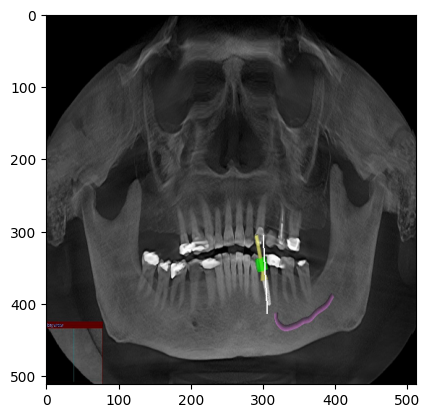

In [459]:
final_line_all[:,1] = 511 - final_line_all[:,1]
# final_line[:,0] = final_line[:,0]-1
# new_img_array = add_line_to_xray(final_line_all, cv2.resize(image, (512,512)))
# new_img_array_1 = add_line_to_rgb(final_line, img_original_array.astype(np.uint8))
new_img_array_2 = add_line_to_rgb(final_line_all, cv2.resize(image_rgb.astype(np.uint8),(512,512)))

In [466]:
image = Image.fromarray(new_img_array_2)

# Save the image as a PNG file
image.save('/content/drive/MyDrive/dental/data/test_implant_3/2113537_p.JPG')

# Calculate accuracy

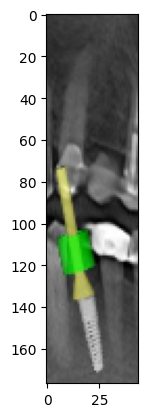

In [463]:
# extract the implant implement
# left_part['y']=511-left_part['y']
# right_part['y']=511-right_part['y']
color_img_array = cv2.resize(image_rgb.astype(np.uint8),(512,512))
box_x_max = right_part['x'].max()
box_x_min = left_part['x'].min()
box_y_min = max(min(left_part['y'].min()-100, right_part['y'].min()-70),0)
box_y_max = min(max(left_part['y'].max()+10, right_part['y'].max()+10),511)
box_img_array = color_img_array[box_y_min:box_y_max,box_x_min:box_x_max,:].astype(np.uint8)
plt.imshow(box_img_array)

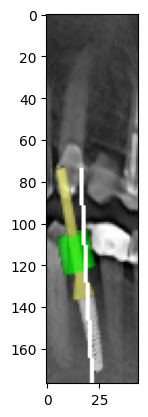

In [464]:
plt.imshow(new_img_array_2[box_y_min:box_y_max,box_x_min:box_x_max,:])

In [ ]:
new_img_array_2[box_y_min:box_y_max,box_x_min:box_x_max,2].max()

255

In [465]:
# computing angle
mask = (box_img_array[:, :, 0] ==box_img_array[:, :, 1]) & (box_img_array[:, :, 0] == box_img_array[:, :, 2])
# mask = (box_img_array[:, :, 0] < 120)  & (box_img_array[:, :, 2] >120) & (abs(box_img_array[:, :, 2]-box_img_array[:, :, 1])>30)
# coordinates_y, coordinates_x = np.where(mask)
coordinates_y, coordinates_x = np.where(~mask)
coordinates_x += box_x_min
coordinates_y += box_y_min
implant_line_reg = LinearRegression().fit(coordinates_y.reshape(-1,1),coordinates_x)
implant_line_slope = implant_line_reg.coef_[0]
# remember which sloope to use
final_line_reg = LinearRegression().fit(final_line[:,0].reshape(-1,1),final_line[:,1])
# final_line_reg = LinearRegression().fit(final_line[:,0].reshape(-1,1),final_line[:,1])
final_line_slope = final_line_reg.coef_[0]
final_line_intercept = final_line_reg.intercept_
angle = (math.atan(implant_line_slope)-math.atan(1/final_line_slope)) / 2 /math.pi * 360
print(implant_line_slope, final_line_slope)
print(angle)

0.16541403210169203 81.85358281781708
8.692533067219362


[[334. 303.]
 [434. 403.]]


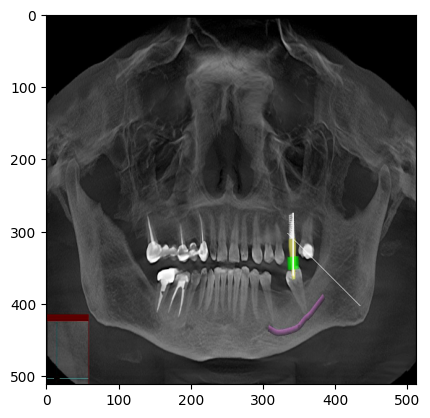

In [264]:
# add the main axes to the rgb image
line_start_y=coordinates_y.min()
line_start_x = coordinates_x[coordinates_y==coordinates_y.min()].min()
line_end_y = coordinates_y.min()+100
line_end_x = line_start_x + 100*implant_line_slope
implant_main_axes=np.array([[line_start_x,line_start_y],[line_end_x,line_end_y]])
print(implant_main_axes)
new_img_array_3 = add_line_to_rgb(implant_main_axes, new_img_array_2)

In [270]:
implant_main_axes_y=np.sort(np.unique(coordinates_y[coordinates_y>360]))
implant_main_axes_x=[]
for i in implant_main_axes_y:
  implant_main_axes_x.append(int(np.max(coordinates_x[coordinates_y==i])))
implant_main_axes_x = np.array(implant_main_axes_x)
implant_main_axes_y = np.array(implant_main_axes_y)
implant_line_reg = LinearRegression().fit(implant_main_axes_y.reshape(-1,1),implant_main_axes_x)
implant_line_slope = implant_line_reg.coef_[0]
print(implant_line_slope, final_line_slope)
print(implant_main_axes_y)
print(implant_main_axes_x)
angle = (math.atan(1/implant_line_slope)-math.atan(1/final_line_slope)) / 2 /math.pi * 360
print(angle)

-0.5 -33.59657148069467
[361 362 363 364 365 366 367 368 369 370 371]
[354 353 348 348 347 348 347 347 347 348 348]
-61.730046639605355


In [78]:
final_line[:,0]

array([173.98057019, 168.250258  , 162.51994581])

In [ ]:
#top point distance
top_point_x = coordinates_x[coordinates_y==coordinates_y.max()]
top_point_y=coordinates_y.max()
distance = np.mean(abs(final_line_slope*top_point_x-top_point_y+final_line_intercept)/np.sqrt(final_line_slope**2+final_line_intercept**2))
print(distance)

0.030001439729854272


In [ ]:
#down point distance
down_point_x = coordinates_x[coordinates_y==coordinates_y.min()]
down_point_y=coordinates_y.min()
distance = np.mean(abs(final_line_slope*down_point_x-down_point_y+final_line_intercept)/np.sqrt(final_line_slope**2+final_line_intercept**2))
print(distance)

0.04759492689227311


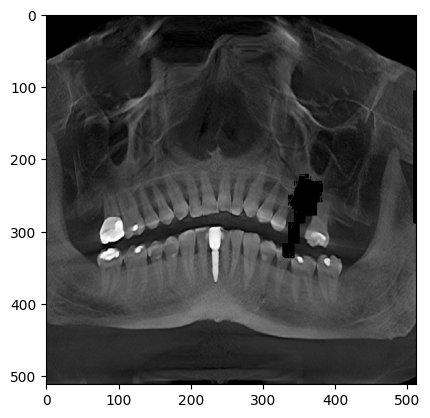

In [ ]:
# slice_implant = (img_original_array[200:400,300:400,:]).astype(np.uint8)
# plt.imshow(slice_implant)
# plt.show()
mask = (img_original_array[:, :, 0] ==img_original_array[:, :, 1]) & (img_original_array[:, :, 0] == img_original_array[:, :, 2])
filtered_array = np.copy(img_original_array)  # Create a copy to keep the original data intact
filtered_array[~mask] = 0
plt.imshow(filtered_array.astype(np.uint8))

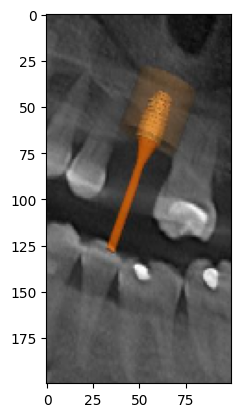

In [ ]:
plt.imshow(img_original_array[200:400,300:400,:].astype(np.uint8))

In [ ]:
image_path_new = "/content/drive/MyDrive/dental/data/samples/sample4.png"
img_new = keras.preprocessing.image.load_img(image_path_new, color_mode='grayscale', target_size=(512, 512))
new_img_array = tf.keras.utils.img_to_array(img_new)
# new_img_array = add_line_to_xray(final_line_all, new_img_array)
new_img_array.max()

255.0

In [ ]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def find_left_cut(left_part, left_line_slope, left_line_intercept):
  left_part_c = left_part.copy()
  i_max = 5000
  i = 0
  while i < i_max:
    i += 1
    new_intercept = left_line_intercept+i
    left_part_c['z'] = left_part_c['x'] * left_line_slope + new_intercept - left_part_c['y']
    if np.sum(left_part_c['z']>0) == 1:
      abline(left_line_slope, new_intercept)
      return new_intercept, left_part_c[left_part_c['z']>0][['x','y']]
  return 'error'

def find_right_cut(right_part, left_line_slope, left_cut_intercept):
  right_part_c = right_part.copy()
  i_max = 500
  i = 0
  while i < i_max:
    i += 0.01
    new_intercept = left_cut_intercept+i
    right_part_c['z'] = right_part_c['x'] * left_line_slope + new_intercept - right_part_c['y']
    if np.sum(right_part_c['z']<0) == 1:
      abline(left_line_slope, new_intercept)
      return new_intercept, right_part_c[right_part_c['z']<0][['x','y']]
  return 'error'


In [ ]:
right_line = PCA_fit(right_part.values)
right_line_slm = LinearRegression().fit(right_line[0].reshape(-1,1), right_line[1])
right_line_slope = right_line_slm.coef_[0]
right_line_intercept = right_line_slm.intercept_
right_cut_intercept, right_point = find_right_cut(right_part, right_line_slope, right_line_intercept)
left_cut_intercept, left_point = find_left_cut(left_part, right_line_slope, right_cut_intercept)
plt.plot(left_point['x'], left_point['y'], marker = 'o')
plt.plot(right_point['x'], right_point['y'], marker = 'o')
plt.plot(left_part['x'], left_part['y'])
right_ten = right_part[(right_part['x']>=right_point['x'].values[0]) & (right_part['y']<=right_point['y'].values[0])].sort_values(by='x',ascending=True).head(10)
right_ten_slr = LinearRegression().fit(right_ten['x'].values.reshape(-1,1),right_ten['y'].values)
right_ten_slope = right_ten_slr.coef_
right_ten_intercept = right_ten_slr.intercept_
left_ten = left_part[(left_part['x']<=left_point['x'].values[0]) & (left_part['y']<=left_point['y'].values[0])].sort_values(by='x',ascending=False).head(10)
left_ten_slr = LinearRegression().fit(left_ten['x'].values.reshape(-1,1),left_ten['y'].values)
left_ten_slope = left_ten_slr.coef_
left_ten_intercept = left_ten_slr.intercept_
abline(right_ten_slope, right_ten_intercept)
abline(left_ten_slope, left_ten_intercept)

beta = np.arctan(left_ten_slope)
alpha = np.arctan(-right_ten_slope)
central_slope = 1/ np.tan((alpha- beta)/2)
central_point_x = (right_point['x'].values[0]+left_point['x'].values[0])/2
central_point_y = (right_point['y'].values[0]+left_point['y'].values[0])/2
central_intercept = central_point_y - central_slope * central_point_x
plt.plot(central_point_x, central_point_y, marker = 'o')
abline(central_slope, central_intercept)
plt.show()